In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import Embedding,Dense,LSTM, Bidirectional,Dropout

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/athar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}','-','-'])

In [5]:
train = pd.read_pickle('./datasets/train.pkl')
val = pd.read_pickle('./datasets/val.pkl')
test = pd.read_pickle('./datasets/test.pkl')

In [6]:
vocabulary = set()
train["text"].str.lower().str.split().apply(vocabulary.update)
vocab_size = len(vocabulary)
print(vocab_size)

43066


In [7]:
with open('./datasets/vocab_data.json', 'r') as fp:
    data = json.load(fp)

In [8]:
vocab=data['vocab']

In [9]:
total_categories=len(vocab)

In [10]:
import io

def load_vectors(fname):
    """Reading text file line by line wkere at first index of line we have word as index for embedding vector
    :fname: filepath"""
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        word=tokens[0]
        embedings=np.asarray(tokens[1:],dtype='float32')
        data[word]=embedings
    return data

In [11]:
embeding_index=load_vectors('crawl-300d-2M.vec')

### Data Pipline

In [12]:
max_seqlen = 200
batch_size = 32
auto = tf.data.AUTOTUNE
tf.random.set_seed(1234)

def make_dataset(df, is_train=True):

    labels= np.array([np.array(i) for i in df.labels])
    dataset = tf.data.Dataset.from_tensor_slices( (df["text"].values,labels  ) )
    dataset = dataset.shuffle(batch_size * 32 ) if is_train else dataset
    
    return dataset.batch(batch_size)

In [13]:
train_dataset = make_dataset(train, is_train=True)
validation_dataset = make_dataset(val, is_train=False)
test_dataset = make_dataset(test, is_train=False)

2022-04-08 14:44:23.369586: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 14:44:23.388610: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81223888 exceeds 10% of free system memory.
2022-04-08 14:44:23.572172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25384936 exceeds 10% of free system memory.


In [14]:
@tf.keras.utils.register_keras_serializable()
def clean_text(input_data):
    
    lowercase = tf.strings.lower(input_data)
    cleaned_stopwords=tf.strings.regex_replace(lowercase, r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*',"")
    cleaned_text=tf.strings.regex_replace(cleaned_stopwords,'[%s]' % re.escape(string.punctuation),'')
    return cleaned_text


In [15]:
vectorizer = layers.TextVectorization(
    standardize = clean_text,
    max_tokens = vocab_size,
    output_mode = 'int',
output_sequence_length = max_seqlen )

train_text = train_dataset.map(lambda x, y: x)
with tf.device("/CPU:0"):
    vectorizer.adapt(train_text)

2022-04-08 14:44:23.821945: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81223888 exceeds 10% of free system memory.
2022-04-08 14:44:24.153140: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81223888 exceeds 10% of free system memory.


In [40]:
vectorizer('dog my amazing')

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([1740, 8294,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [16]:
def get_vectoriz_dataset(dataset):
    dataset=dataset.map(lambda text, label: (vectorizer (text), label), num_parallel_calls=auto).prefetch(auto)
    return dataset

In [17]:
train_dataset = get_vectoriz_dataset(train_dataset)

validation_dataset = get_vectoriz_dataset(validation_dataset)

test_dataset = get_vectoriz_dataset(test_dataset)

### Embedding Matrix

In [18]:
number_words=vectorizer.vocabulary_size()+1
embeddings_dimension=300

In [39]:
embeding_index.get('my')

array([-2.812e-01, -5.300e-03, -4.720e-02, -9.710e-02,  2.170e-02,
        9.590e-02,  2.676e-01, -3.328e-01,  1.734e-01,  1.207e-01,
        6.260e-02,  3.386e-01,  8.930e-02, -6.400e-02,  2.372e-01,
       -2.236e-01, -2.600e-03, -1.032e-01, -1.390e-02,  1.356e-01,
       -5.800e-02,  5.980e-02, -1.746e-01,  7.590e-02, -7.850e-02,
       -3.060e-02,  1.872e-01,  7.100e-03, -9.080e-02, -1.600e-02,
       -1.288e-01,  4.150e-02, -1.083e-01, -3.960e-01,  1.346e-01,
       -1.291e-01,  1.338e-01, -5.330e-02, -4.420e-02, -1.867e-01,
        2.900e-02, -1.862e-01,  1.645e-01,  3.422e-01, -2.930e-02,
       -7.690e-02,  8.720e-02, -5.750e-02,  2.144e-01,  6.240e-02,
       -5.680e-02,  7.320e-02,  6.945e-01, -1.490e-01, -2.383e-01,
       -2.679e-01, -6.040e-02, -4.241e-01, -9.020e-02,  2.810e-02,
       -2.650e-02, -3.018e-01, -7.400e-02,  5.780e-02,  1.296e-01,
       -4.030e-02,  1.341e-01, -2.513e-01, -1.038e-01,  1.420e-02,
       -1.770e-01,  5.240e-02, -8.940e-02,  2.096e-01,  7.890e

In [19]:
embeddings_matrix= np.zeros((number_words,embeddings_dimension))

In [20]:
for index ,word  in enumerate(vectorizer.get_vocabulary()):
    
    embeding_vector=embeding_index.get(word)
    
    if embeding_vector is not None:
        embeddings_matrix[index]=embeding_vector
    else:
        print(f"{word} not found")
     

In [21]:
from tensorflow.keras import regularizers
def get_model():
    
        model = tf.keras.Sequential()
        # embedding layer
        model.add( Embedding( number_words,embeddings_dimension,input_length=max_seqlen, weights=[embeddings_matrix],trainable=False) )
        #  first LSTM layer
        model.add( Bidirectional( LSTM(units=64,return_sequences= True) ) )
        #  second LSTM layer
        model.add(Bidirectional( LSTM(units=32,return_sequences=False) ) )
        #  first Dense layer
        model.add( Dense( units=512,activation='relu' ))
#         model.add(Dropout(0.2))
        #  Second Dense layer
        model.add( Dense( units=256,activation='relu' ))
#         model.add(Dropout(0.2))
        #   output layer
        model.add( Dense(units=total_categories,activation='sigmoid') )
        return model

In [22]:
epochs = 20
lr=0.001
model = get_model()
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=["categorical_accuracy"] )

history = model.fit( train_dataset, validation_data=validation_dataset, epochs=epochs )



2022-04-08 14:44:25.613433: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 39892800 exceeds 10% of free system memory.


Epoch 1/20
899/899 [==============================] - 198s 214ms/step - loss: 0.0287 - categorical_accuracy: 0.2408 - val_loss: 0.0175 - val_categorical_accuracy: 0.3961
Epoch 2/20
899/899 [==============================] - 191s 212ms/step - loss: 0.0136 - categorical_accuracy: 0.6785 - val_loss: 0.0104 - val_categorical_accuracy: 0.8401
Epoch 3/20
899/899 [==============================] - 197s 219ms/step - loss: 0.0085 - categorical_accuracy: 0.8162 - val_loss: 0.0075 - val_categorical_accuracy: 0.7745
Epoch 4/20
899/899 [==============================] - 197s 219ms/step - loss: 0.0062 - categorical_accuracy: 0.7594 - val_loss: 0.0059 - val_categorical_accuracy: 0.7779
Epoch 5/20
899/899 [==============================] - 198s 220ms/step - loss: 0.0048 - categorical_accuracy: 0.7434 - val_loss: 0.0049 - val_categorical_accuracy: 0.7177
Epoch 6/20
899/899 [==============================] - 199s 221ms/step - loss: 0.0039 - categorical_accuracy: 0.7349 - val_loss: 0.0047 - val_categoric

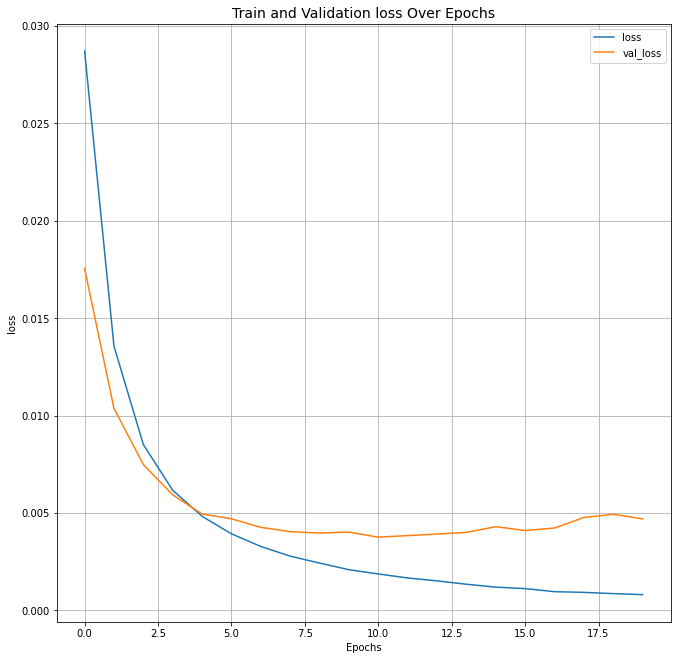

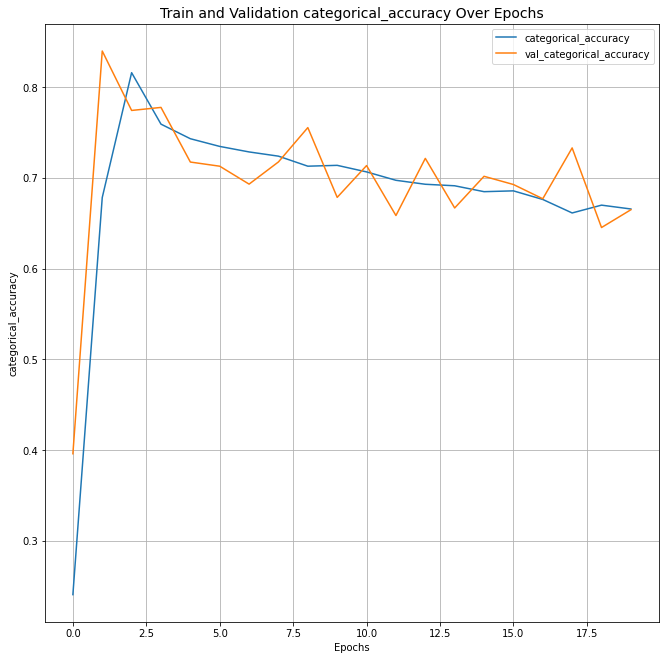

In [23]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.figure(figsize=(11,11))
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [24]:
_, categorical_acc = model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

281/281 [==============================] - 18s 64ms/step - loss: 0.0047 - categorical_accuracy: 0.6728
Categorical accuracy on the test set: 67.28%.


In [25]:
model2= keras.Sequential([vectorizer, model])

In [26]:
model2.save('./model/bestbuy_model',save_format='tf')

2022-04-08 15:51:01.590873: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/bestbuy_model/assets


INFO:tensorflow:Assets written to: ./model/bestbuy_model/assets


In [27]:
model_ex=tf.keras.models.load_model('./model/bestbuy_model',compile=False)

In [28]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0] ## removing dimension to have 1D array
    return np.take(vocab, hot_indices)

In [29]:
def get_labels(probilities,vocab=vocab):
    
    predicted_proba = [proba for proba in probilities]
    iterator =zip(predicted_proba,vocab)
    iterator_sorted = sorted(iterator,key=lambda tupl:tupl[0],reverse=True) ## sorting based on probabilities
    predicted_lables = [x for _,x in iterator_sorted]
    
    return predicted_lables
    
def inference(data,is_train= False):
    """ self explanatory """
    
    dataset = make_dataset(data,is_train)
    text_batch, label_batch = next(iter(dataset))
    predicted_probabilties = model_ex.predict(text_batch) ##tensor of shape (batch_size,categories)
    for i, text in enumerate(text_batch[:5]):
        label = label_batch[i].numpy()[None, ...] ## adding newaxis at the 
        print(f"text: {text}\n")
        print(f"Label(s): {invert_multi_hot(label[0])}\n")
        
        predicted_proba = [proba for proba in predicted_probabilties[i]]
        pred_labels=get_labels(predicted_proba)
    return pred_labels[:3]
        

In [42]:
predictions=inference(test.sample(10))

print(f"Top3 prediction: {predictions}")

text: b'JACK SPADE - Folio Case for Apple\xc2\xae iPad\xc2\xae Air 2 - Navy Compatible with Apple iPad Air 2; microfiber lining; typing mode; hands-free viewing mode; magnetic closure; sleep/wake compatible'

Label(s): ['Computers & Tablets' 'iPad & Tablet Accessories'
 'Cases, Covers & Keyboard Folios']

text: b'Boston Acoustics - A360 6-1/2" 3-Way Floor Speaker (Each) - Gloss Black 400W peak power; dual 6-1/2" cone woofers with Deep Channel Design magnets; 1" Kortec soft-dome tweeter; 3-1/2" midrange; gold-plated, 5-way binding posts'

Label(s): ['Audio' 'Home Audio' 'Speakers']

text: b'Easy LP to MP3 - Windows Bring your music into the modern era'

Label(s): ['Computers & Tablets' 'Software' 'Design & Illustration']

text: b'Projecta - Perm-Wall 106" Fixed Projector Screen - White From our expanded online assortment; 52"H x 92"W viewing area; Da-Mat screen surface; easy installation'

Label(s): ['TV & Home Theater' 'TV Stands, Mounts & Furniture'
 'Projector Mounts & Screens']

tex

In [31]:
def real_time_prediction(text):
    text=tf.expand_dims(text,axis=0)
    prob=model_ex.predict(text)
    return get_labels(prob[0])[:3]

In [32]:
 real_time_prediction('H2O - Bolt 3-in-1 SIM Card H2O Bolt 3-in-1 SIM Card: Compatible with most H2O Bolt or other GSM tablets, e-readers and hotspots; works with H2O Bolt network; 4G LTE speed')

['Cell Phones', 'Cell Phone Accessories', 'SIM Cards']

In [33]:
model.save("./model/bestbuy_model1",save_format='tf')

INFO:tensorflow:Assets written to: ./model/bestbuy_model1/assets


INFO:tensorflow:Assets written to: ./model/bestbuy_model1/assets


In [34]:
model1=tf.keras.models.load_model('./model/bestbuy_model1',compile=False)